# Importing Necessary Packages


In [11]:
import numpy as np
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data Preparation


In [4]:
train_transform=transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_dataset = datasets.MNIST('./data', train=True, download=True,
                       transform=train_transform)
test_dataset = datasets.MNIST('./data', train=False,
                       transform=test_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=128,
                                             shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                             shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_size =len(train_dataset)

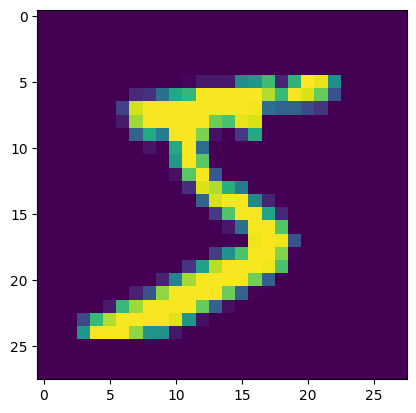

In [3]:
plt.imshow(train_dataset[0][0][0], cmap='viridis')

# CNN Model


In [5]:
class MNIST(nn.Module):
    '''
    Input: 28x28
    Output: 10
    '''
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=0, stride=1),  # 16x24x24
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
            )
    def forward(self, xb):
        return self.network(xb)

In [9]:
def train_test(model, criterion, optimizer, num_epochs=30):
    train_loss = []
    train_accuracy = []
    val_accuracy = []
    val_loss = []
    history = dict()
    model.train()
    for epoch in range(num_epochs):
        model.train()
        running_training_loss = 0.0
        running_training_accuracy = 0.0
        total_training_predictions = 0

        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_training_loss += loss.item()*inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_training_predictions += labels.size(0)
            running_training_accuracy += (predicted == labels).sum().item()
        epoch_training_accuracy = running_training_accuracy / train_size*100
        epoch_training_loss = running_training_loss / train_size

        print(f'Epoch:{epoch + 1}, training accuracy: {round(epoch_training_accuracy, 3)}%, training loss: {round(epoch_training_loss, 3)}')

        train_loss.append(epoch_training_loss)
        train_accuracy.append(epoch_training_accuracy)
        
        model.eval()
        correct = 0
        total = 0
        running_val_loss = 0.0
        
        with torch.no_grad():
            for data in test_dataloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                
                running_val_loss += loss.item()*inputs.size(0)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            epoch_val_accuracy = correct / total *100
            epoch_val_loss = running_val_loss / total
            val_accuracy.append(epoch_val_accuracy)
            val_loss.append(epoch_val_loss)
                

    history['train_loss'] = train_loss
    history['train_accuracy'] = train_accuracy
    history['val_accuracy'] = val_accuracy
    history['val_loss'] = val_loss
    
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on test images: {round(accuracy, 2)}%')
    return history

In [10]:
model = MNIST().to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
history = train_test(model, criterion, optimizer_ft,
           num_epochs=30)

Epoch:1, training accuracy: 84.208%, training loss: 0.501
Epoch:2, training accuracy: 92.225%, training loss: 0.255
Epoch:3, training accuracy: 93.33%, training loss: 0.217
Epoch:4, training accuracy: 94.34%, training loss: 0.191
Epoch:5, training accuracy: 94.755%, training loss: 0.173
Epoch:6, training accuracy: 95.087%, training loss: 0.162
Epoch:7, training accuracy: 95.257%, training loss: 0.157
Epoch:8, training accuracy: 95.572%, training loss: 0.146
Epoch:9, training accuracy: 95.71%, training loss: 0.138
Epoch:10, training accuracy: 95.893%, training loss: 0.134
Epoch:11, training accuracy: 96.165%, training loss: 0.129
Epoch:12, training accuracy: 96.213%, training loss: 0.124
Epoch:13, training accuracy: 96.285%, training loss: 0.122
Epoch:14, training accuracy: 96.518%, training loss: 0.117
Epoch:15, training accuracy: 96.607%, training loss: 0.112
Epoch:16, training accuracy: 96.662%, training loss: 0.109
Epoch:17, training accuracy: 96.847%, training loss: 0.106
Epoch:18,

In [48]:
print(model)

Net(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=9216, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
loss_cnn = history['val_loss'][-1]
accuracy_cnn = history['val_accuracy'][-1]
print('Test loss:', loss_cnn)
print('Test accuracy:', accuracy_cnn)

Test loss: 0.01660919804603909
Test accuracy: 99.25


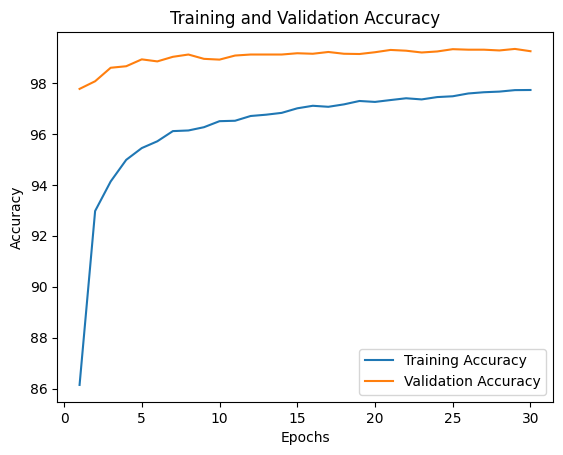

In [12]:

train_acc = history['train_accuracy']
val_acc = history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

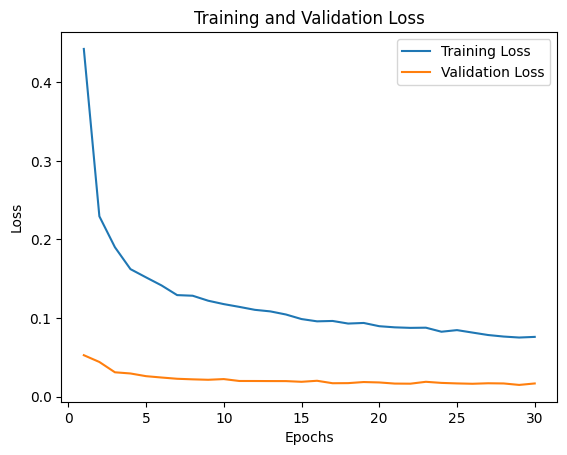

In [13]:
train_loss = history['train_loss']
val_loss = history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()